In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import cv2
import os

from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# loading images 
def load_training_data(file_path = 'A1_data/train_data.csv', images_folder = 'A1_data/modified_data/'):
    train_df = pd.read_csv('A1_data/train_data.csv')
    train_df['path']  = np.nan
    for subdir, dirs, files in os.walk(images_folder):
        for file in files:
            path = os.path.join(subdir, file)
            file_ext = os.path.splitext(path)[-1].lower()
            if (file_ext == '.jpg'):
                train_df.loc[train_df['filename'] == path.split('\\')[-1], ['path']] = path
    return train_df


#Plotting classes count for both shapes and sign
def plot_classes_count(df):
    fig = plt.figure(figsize=(16, 5))
    columns = 2
    rows = 1
    for i in range(0, columns * rows):
        fig.add_subplot(rows, columns, i + 1)
        if (i == 1):
            df['tilt'].value_counts().plot.bar()
            plt.xlabel('Tilt angle')
            plt.ylabel('Count')
        else:
            df['pan'].value_counts().plot.bar()
            plt.xlabel('Pan angle')
            plt.ylabel('Count')
    plt.show()

    
# Plotting images from our dataset    
def plot_images(df):
    df_percent = df.sample(frac=0.01).reset_index()
    fig = plt.figure(figsize=(13, 5))
    columns = 6
    rows = 2
    for i in range(0, columns * rows):
        fig.add_subplot(rows, columns, i + 1)
        im = cv2.imread(df_percent['path'][i])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        plt.title("tilt : " + str(df_percent['tilt'][i]) + "\n" + "pan : " + str(df_percent['pan'][i]))
        plt.axis('off')
        plt.imshow(im)

#converting image to array for CNN
def convert_images_to_array(df):
    images_path = df['path']
    images = []

    for image in images_path:
        im = cv2.imread(image, cv2.IMREAD_UNCHANGED)
#         if (im.shape[0] < 28):
#             im = cv2.resize(im, (28, 28))
        im = im.astype(np.float32)
        im /= 255.0 
        images.append(im)
        
    images = np.array(images)
    return images

# Label encoding our categorical target variable
def label_encoding(y):
    le = LabelEncoder()
    y = le.fit_transform(y)  
    return y, le

In [3]:
train_data = load_training_data()

In [4]:
train_data.head(10)

,filename,person_id,series,tilt,pan,path
0,face_790.jpg,5,1,-15,30,A1_data/modified_data/modified_data\face_790.jpg
1,face_2445.jpg,5,1,0,-75,A1_data/modified_data/modified_data\face_2445.jpg
2,face_2266.jpg,5,2,-15,-60,A1_data/modified_data/modified_data\face_2266.jpg
3,face_2713.jpg,5,2,0,-90,A1_data/modified_data/modified_data\face_2713.jpg
4,face_2016.jpg,5,2,15,-75,A1_data/modified_data/modified_data\face_2016.jpg
5,face_2522.jpg,5,1,30,60,A1_data/modified_data/modified_data\face_2522.jpg
6,face_1254.jpg,5,2,15,-15,A1_data/modified_data/modified_data\face_1254.jpg
7,face_2754.jpg,5,1,15,-45,A1_data/modified_data/modified_data\face_2754.jpg
8,face_201.jpg,5,2,30,-90,A1_data/modified_data/modified_data\face_201.jpg
9,face_931.jpg,5,1,15,-30,A1_data/modified_data/modified_data\face_931.jpg


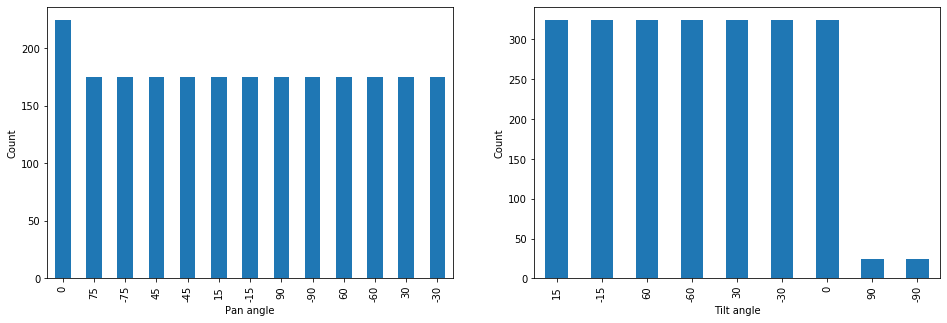

In [5]:
plot_classes_count(train_data)

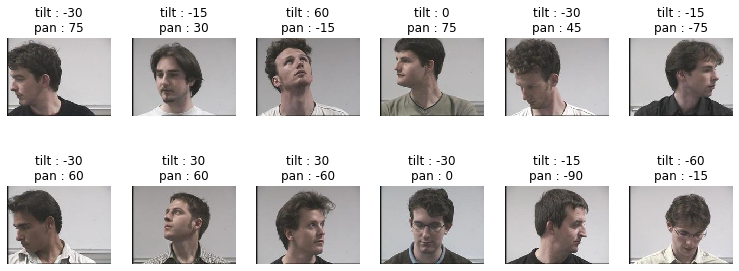

In [6]:
plot_images(train_data)

In [7]:
train_data['label'] = train_data['tilt'].apply(str) + "," + train_data['pan'].apply(str)

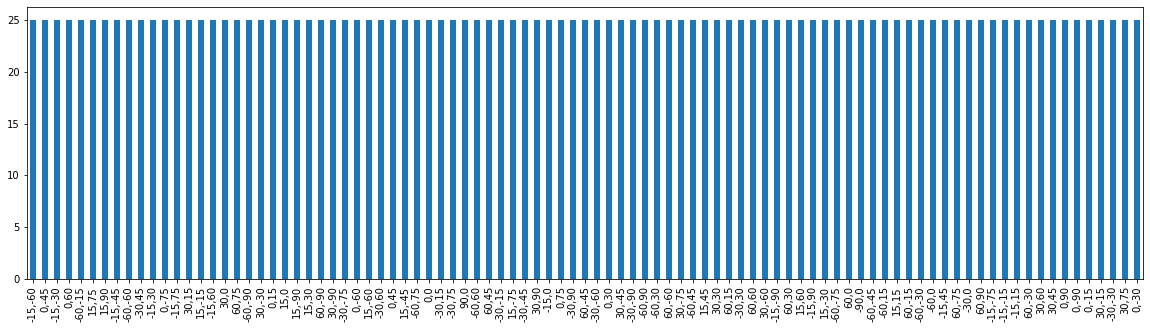

In [8]:
train_data['label'].value_counts().plot.bar(figsize=(20, 5))

In [9]:
X = convert_images_to_array(train_data)

In [10]:
y = train_data['label']
shape_classes = np.unique(y).shape[0]

In [11]:
# Label encoding our categorical target variables to numerical form
y, le = label_encoding(y)


In [12]:
y = keras.utils.to_categorical(y, 93)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42, shuffle = True)

In [14]:
# Defining our Convolutional Neural Network
def build_model(n_classes, input_shape):
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape= input_shape))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3)))
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))

    model.add(Flatten())
    model.add(Dense(200, activation='relu'))

    model.add(Dropout(rate=0.5))
    model.add(Dense(93, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [15]:
# Creating model instance
model = build_model(shape_classes, (144, 192, 3))

#Displaying model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 140, 188, 32)      2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 138, 186, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 138, 186, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 69, 93, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 69, 93, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 67, 91, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 67, 91, 64)       

In [ ]:
# using 20 epochs for the training and saving the accuracy for each epoch
epochs = 20

#Stopping model if validation accuracy remain sames for 5 epochs straight
callback = ModelCheckpoint(filepath="./model.hdf5", monitor="val_accuracy", verbose=0,
        save_best_only=True, mode="auto")

es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 2, patience = 5)

#Training our model
history = model.fit(X_train, y_train, batch_size = 16, epochs = epochs, verbose = 2, callbacks = [es, callback],
          validation_data = (X_val, y_val))

Train on 1860 samples, validate on 465 samples
